In [2]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from sklearn.cluster import KMeans
from scipy.ndimage import binary_dilation
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors

In [3]:
tile = '11SKU'
location = 'Isla_Vista_Kelp'
save_mask = True
save_classification = True

path = os.path.join(r'C:\Users\attic\HLS_Kelp\imagery',location,tile)

granules = os.listdir(path)
for item in granules:
    if os.path.isdir(os.path.join(path,item)):
        img_path = os.path.join(path,item)
        granule = item
        break

img_path = r'C:\Users\attic\HLS_Kelp\imagery\Isla_Vista_Kelp\10SGD\HLS.L30.T10SGD.2018122T183340.v2.0'
files = os.listdir(img_path)
desired_bands = ['B02','B03','B04','B05','B06','B07'] #2,3,4,5,6,7]

pattern = re.compile(r'\.(' + '|'.join(desired_bands) + r')\.tif$')
img_files = [f for f in files if re.search(pattern, f)]

# print(img_files)
if '.csv' in img_files[0]:
    geotiff_path = os.path.join(img_path, img_files[1]) #Geotiff used for aligning DEM 
else:
    geotiff_path = os.path.join(img_path, img_files[0])

In [4]:
with rasterio.open(geotiff_path) as dst:   
    hls = dst.read()
    dem_path = r'C:\Users\attic\HLS_Kelp\imagery\Socal_DEM.tiff'
    dem = rasterio.open(dem_path)
    if (dem.crs != dst.crs):
        reprojected_dem = np.zeros((hls.shape[1], hls.shape[2]), dtype=hls.dtype)
        reproject(
            source=dem.read(),
            destination=reprojected_dem,
            src_transform=dem.transform,
            src_crs=dem.crs,
            dst_transform=dst.transform,
            dst_crs=dst.crs,
            resampling=Resampling.nearest)
    hls_flat = np.squeeze(hls, axis=0)   

if reprojected_dem.any():
    struct = np.ones((5,5))
    land_mask = binary_dilation(reprojected_dem > 0, structure = struct)
    ocean_mask = binary_dilation(reprojected_dem < -60 , structure = struct)
    full_mask = land_mask + ocean_mask
    # plt.figure(figsize=(6, 6))
    # plt.imshow(land_mask, cmap='gray')
    # plt.show()    
    # plt.figure(figsize=(6, 6))
    # plt.imshow(full_mask, cmap='gray')
    # plt.show()
    if save_mask:
        mask_path = os.path.join(path,f'{tile}_fullmask.tif')
        transform = dst.transform  
        height, width = full_mask.shape
        profile = {
            'driver': 'GTiff',
            'width': width,
            'height': height,
            'count': 1,  # one band
            'dtype': rasterio.uint8,  # assuming binary mask, adjust dtype if needed
            'crs': dst.crs,
            'transform': transform,
            'nodata': 0  # assuming no data is 0
        }

        # Write the land mask array to GeoTIFF
        with rasterio.open(mask_path, 'w', **profile) as dst:
            dst.write(full_mask.astype(rasterio.uint8), 1)
else:
    print("Something failed, you better go check...")


In [5]:
img_bands = []
for file in img_files:
    with rasterio.open(os.path.join(img_path,file)) as src:
        img_bands.append(np.where(full_mask, 0, src.read(1))) #Create image with the various bands

img = np.stack(img_bands, axis=0)

n_bands, height, width = img.shape
img_2D = img.reshape(img.shape[0], -1).T #classifier takes 2D array of band values for each pixel 

img_sum = img_2D.sum(axis=1)
img_2D_normalized  = img_2D / img_sum[:,None] #divide value by sum of pixel band values
img_2D_normalized = (img_2D_normalized * 255)
img_2D_normalized = img_2D_normalized.astype(np.uint8)

C:\Users\attic\AppData\Local\Temp\ipykernel_13564\439493543.py:12: RuntimeWarning: divide by zero encountered in divide
  img_2D_normalized  = img_2D / img_sum[:,None] #divide value by sum of pixel band values
C:\Users\attic\AppData\Local\Temp\ipykernel_13564\439493543.py:12: RuntimeWarning: invalid value encountered in divide
  img_2D_normalized  = img_2D / img_sum[:,None] #divide value by sum of pixel band values
C:\Users\attic\AppData\Local\Temp\ipykernel_13564\439493543.py:14: RuntimeWarning: invalid value encountered in cast
  img_2D_normalized = img_2D_normalized.astype(np.uint8)


(3660, 3660, 6)


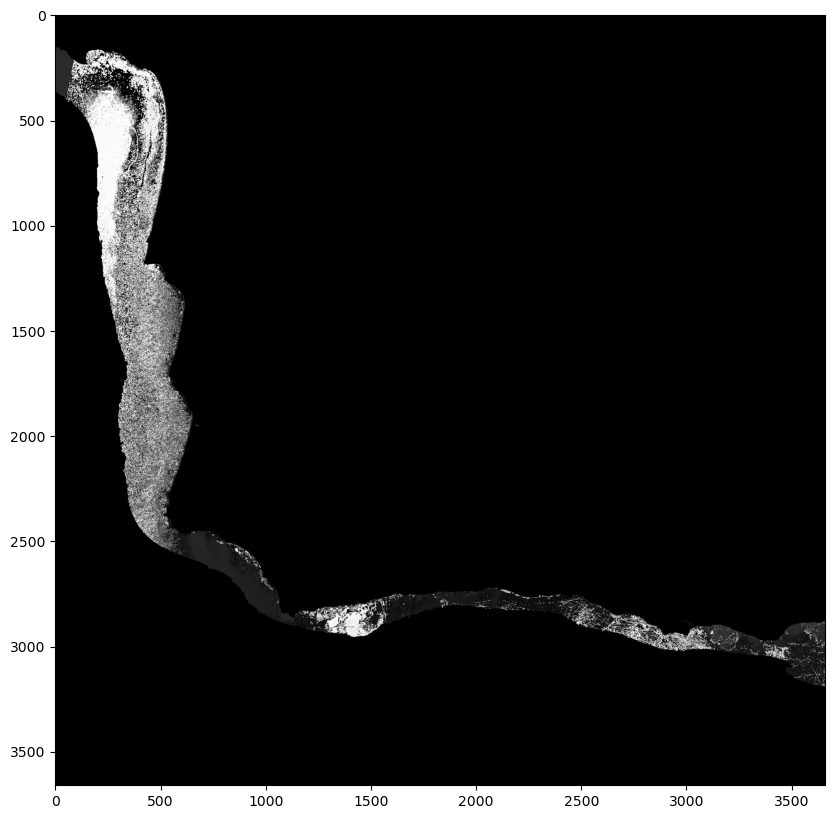

In [6]:

if not os.path.isdir (r'C:\Users\attic\HLS_Kelp\imagery\rf_prepped'):
    os.mkdir(r'C:\Users\attic\HLS_Kelp\imagery\rf_prepped')
classification_path = os.path.join(r'C:\Users\attic\HLS_Kelp\imagery\rf_prepped',f'{granule}_rf_ready.tif')
transform = dst.transform  
reshaped_normalized_img = img_2D_normalized.reshape(height, width, 6)
print(reshaped_normalized_img.shape)
plt.figure(figsize=(10, 10))
plt.imshow(reshaped_normalized_img[:,:,3], cmap='gray')
plt.show()  

num_bands = 6
data_type = rasterio.uint8
profile = {
    'driver': 'GTiff',
    'width': width,
    'height': height,
    'count': 6,  # one band
    'dtype': data_type,  # assuming binary mask, adjust dtype if needed
    'crs': dst.crs,
    'transform': transform,
    'nodata': 0  # assuming no data is 0
}
# Write the land mask array to GeoTIFF
with rasterio.open(classification_path, 'w', **profile) as dst:
    for i in range(num_bands):
        dst.write(reshaped_normalized_img[:,:,i].astype(data_type), i + 1)